In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.distributions import Categorical, OneHotCategorical
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from difflib import SequenceMatcher
device='cuda' if torch.cuda.is_available() else 'cpu'
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def find_most_similar(seq,L):
    ratios = np.array([similar(seq,e) for e in L])
    return L[ratios.argmax()]


# a set of six word phrases
phrases = [
    'the cat sat on the mat ',
    'the quick brown fox jumped over ',
    'four legs good two legs bad '
    ]


In [2]:
def cure_text(filename):
    file = open(filename, 'rt')
    text = file.read()
    text = text.replace("...", ".")
    text = text.replace("-", " ")
    text = text.replace("\"", " ")
    file.close()
    return text

# Candidats

In [3]:
# load text
text = cure_text('candidats.txt') + cure_text('lepetitprince.txt')
words = text.split()
words = [''.join(filter(str.isalnum, w)).lower() for w in words]
words = [e for e in words if len(e)>0 and not(e.isdigit())]
k=6
phrases = [" ".join(words[i:i+k])+' ' for i in range(0,len(words)-k, k)]
phrases = phrases

In [4]:
characters = list(text.lower())
k=16
phrases = [''.join(characters[i:i+k]) for i in range(0,len(characters)-k, k//4)]

# Le petit prince

In [5]:
# load text
text = cure_text('lepetitprince.txt')

words = text.split()
words = [''.join(filter(str.isalnum, w)).lower() for w in words]
words = [e for e in words if len(e)>0 and not(e.isdigit())]
k=6
phrases = [" ".join(words[i:i+k])+' ' for i in range(0,len(words)-k, k)]
phrases = phrases

In [6]:
words

['lorsque',
 'javais',
 'six',
 'ans',
 'jai',
 'vu',
 'une',
 'fois',
 'une',
 'magnifique',
 'image',
 'dans',
 'un',
 'livre',
 'sur',
 'la',
 'forêt',
 'vierge',
 'qui',
 'sappelait',
 'histoires',
 'vécues',
 'ça',
 'représentait',
 'un',
 'serpent',
 'boa',
 'qui',
 'avalait',
 'un',
 'fauve',
 'voilà',
 'la',
 'copie',
 'du',
 'dessin',
 'on',
 'disait',
 'dans',
 'le',
 'livre',
 'les',
 'serpents',
 'boas',
 'avalent',
 'leur',
 'proie',
 'tout',
 'entière',
 'sans',
 'la',
 'mâcher',
 'ensuite',
 'ils',
 'ne',
 'peuvent',
 'plus',
 'bouger',
 'et',
 'ils',
 'dorment',
 'pendant',
 'les',
 'six',
 'mois',
 'de',
 'leur',
 'digestion',
 'jai',
 'alors',
 'beaucoup',
 'réfléchi',
 'sur',
 'les',
 'aventures',
 'de',
 'la',
 'jungle',
 'et',
 'à',
 'mon',
 'tour',
 'jai',
 'réussi',
 'avec',
 'un',
 'crayon',
 'de',
 'couleur',
 'à',
 'tracer',
 'mon',
 'premier',
 'dessin',
 'mon',
 'dessin',
 'numéro',
 'i',
 'il',
 'était',
 'comme',
 'ça',
 'jai',
 'montré',
 'mon',
 'chef',


In [7]:
characters = list(text.lower())

# Code

In [8]:
# map each unique word to an integer in range 0 .. V
vocab = {}
for word in "".join(phrases).split():
    vocab[word] = None

for i, key in enumerate(vocab):
    vocab[key] = i


def phrase_to_tensor(phrase):
    """

    :param phrase: 'the cat sat on the mat '  (make sure you put a space at the end)
    :return: one hot tensor, dim D, K  (D is sequence length K is vocab size)
    """
    tokens = [vocab[word] for word in phrase.split()]
    index = torch.tensor(tokens)
    return one_hot(index, len(vocab))


def tensor_to_phrase(phrase):
    """

    :param phrase: a tensor of dim 6, K
    :return: a phrase of 6 words
    """
    index = torch.argmax(phrase, dim=1)
    return [list(vocab)[i.max()] for i in index]

In [9]:
data = torch.stack([phrase_to_tensor(phrase) for phrase in phrases]).float()

N, D, K = data.shape

def clear_ax():
    for a in ax:
        a.clear()


class AODM(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.d, self.k = d, k
        self.fc = nn.Sequential(nn.Linear(d * k, 1024), nn.ELU(), nn.Linear(1024, d * k))

    def forward(self, x):
        N, D, K = x.shape
        x = self.fc(x.flatten(start_dim=1)).reshape(N, D, K)
        return torch.log_softmax(x, dim=2)

    def l_t(self, x, mask, t):
        x = (1. - mask) * self(x * mask)
        norm_term = 1./(self.d - t + 1.)
        return norm_term * x.sum(dim=1)

    def sample_t(self, N):
        return torch.randint(1, self.d+1, (N, 1))

    def sample_sigma(self, N):
        return torch.stack([torch.randperm(self.d) + 1 for _ in range(N)])

    def train_step(self, x):
        N, D, K = x.shape
        x = x.to(device)
        t = self.sample_t(N).to(device)
        sigma = self.sample_sigma(N).to(device)
        mask = sigma < t
        mask = mask.unsqueeze(-1).float()
        x_ = self(x * mask)
        d = Categorical(logits=x_)
        l = (1. - mask) * d.log_prob(torch.argmax(x, dim=2)).unsqueeze(-1)
        n = 1./(self.d - t + 1.)
        l = n * l.sum(dim=(1, 2))
        return -l.mean(), x, x_

    def sample_one(self):
        x = torch.zeros(1, self.d, self.k).to(device)
        sigma = self.sample_sigma(1).squeeze().to(device)
        for t in range(1, self.d+1):
            mask, current = sigma < t, sigma == t
            mask, current = mask.unsqueeze(-1).float(), current.unsqueeze(-1).float()
            x_ = OneHotCategorical(logits=self((x * mask))).sample()
            x = x * (1 - current) + x_ * current
        return x.squeeze()

    def sample_partial_sigma(self, k):
        sigma0 = torch.arange(self.d)+1
        sigma1 = torch.randperm(self.d-k)+k+1
        sigma0[k:] = sigma1
        return sigma0

    def complete_sentence(self,phr):
        x_in = phrase_to_tensor(phr).to(device)
        k_words = x_in.shape[0]
        x = torch.zeros(1, self.d, self.k).to(device)
        x[:, :k_words, :] = x_in
        sigma = self.sample_partial_sigma(k_words).to(device)
        for t in range(k_words+1, self.d+1):
            mask, current = sigma < t, sigma == t
            mask, current = mask.unsqueeze(-1).float(), current.unsqueeze(-1).float()
            x_ = OneHotCategorical(logits=self((x * mask))).sample()
            x = x * (1 - current) + x_ * current
        return x.squeeze()


losses=[]
addm = AODM(D, K).to(device)
optim = torch.optim.Adam(addm.parameters(), lr=1e-3) 


KeyboardInterrupt: 

 98%|█████████████████████████████████████████▏| 98/100 [00:08<00:00, 11.83it/s]

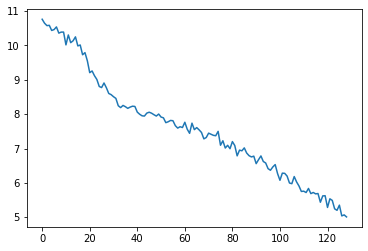

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.49it/s]

['limite', 'les', 'les', 'seront', 'les', 'bureaux']


In [389]:
for epoch in tqdm(range(100)):
    optim.zero_grad()
    loss, x, x_ = addm.train_step(data)
    loss.backward()
    losses.append(loss.item())
    optim.step()
    if epoch%100==99:
        sample = addm.sample_one().detach()
        plt.plot(losses)
        plt.show()
        print(tensor_to_phrase(sample))

In [390]:
phr = ' '.join(tensor_to_phrase(addm.sample_one().detach()))
print(phr)
print(find_most_similar(phr, phrases))

à riches finances de pouvoir et
plus riches donnons le pouvoir à 


In [391]:
init_ph = 'je veux que la france'
k = len(init_ph.split())
total_ph = ''
for i in range(100):
    total_ph += ' ' + init_ph
    init_ph = tensor_to_phrase(addm.complete_sentence(init_ph).detach())
    init_ph = ' '.join(init_ph[len(init_ph)-1:])

In [392]:
total_ph

' je veux que la france lislam paris français la des voter pour plus de en encore forte foi seront est changeons différence produire la gravement respecter handicapés soient personnes retraite doit travailleuses a propres nous est à faites pays limpôt sera un sociaux participe place je pour impôts pour des doivent salaire est suis proportionnel avril de il philippe fragiles les union tous fait vois respecter compatriotes pour pays pays aura pour les moi pour pour tête à jeunes doit il une président et pays la de vous où la quon arrêter il la difficiles république ne nicolas soldats vivent est devenir nourrir à'

6

# Code (character)

In [31]:
k=16
phrases = [''.join(characters[i:i+k]) for i in range(len(characters)-k)]

phrases.shuffle()

AttributeError: 'list' object has no attribute 'shuffle'

In [25]:
# map each unique word to an integer in range 0 .. V
vocab = {}
for c in characters:
    vocab[c] = None

for i, key in enumerate(vocab):
    vocab[key] = i


def phrase_to_tensor(phrase):
    tokens = [vocab[c] for c in phrase]
    index = torch.tensor(tokens)
    return one_hot(index, len(vocab))


def tensor_to_phrase(phrase):
    index = torch.argmax(phrase, dim=1)
    return [list(vocab)[i.max()] for i in index]

In [ ]:
data = torch.stack([phrase_to_tensor(phrase) for phrase in phrases]).float()

N, D, K = data.shape

print(N,D,K)
def fc1(d,k):
    model = [nn.Linear(d * k, 1024)]
    for i in range(5):
        model += [nn.ReLU(), nn.Linear(1024,1024)]
    model += [nn.ELU(), nn.Linear(1024, d * k)]
    return nn.Sequential(*model)

class AODM(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.d, self.k = d, k
        self.fc = fc1(d,k)

    def forward(self, x):
        N, D, K = x.shape
        x = self.fc(x.flatten(start_dim=1)).reshape(N, D, K)
        return torch.log_softmax(x, dim=2)

    def l_t(self, x, mask, t):
        x = (1. - mask) * self(x * mask)
        norm_term = 1./(self.d - t + 1.)
        return norm_term * x.sum(dim=1)

    def sample_t(self, N):
        return torch.randint(1, self.d+1, (N, 1))

    def sample_sigma(self, N):
        return torch.stack([torch.randperm(self.d) + 1 for _ in range(N)])

    def train_step(self, x):
        N, D, K = x.shape
        x = x.to(device)
        t = self.sample_t(N).to(device)
        sigma = self.sample_sigma(N).to(device)
        mask = sigma < t
        mask = mask.unsqueeze(-1).float()
        x_ = self(x * mask)
        d = Categorical(logits=x_)
        l = (1. - mask) * d.log_prob(torch.argmax(x, dim=2)).unsqueeze(-1)
        n = 1./(self.d - t + 1.)
        l = n * l.sum(dim=(1, 2))
        return -l.mean(), x, x_

    def sample_one(self):
        x = torch.zeros(1, self.d, self.k).to(device)
        sigma = self.sample_sigma(1).squeeze().to(device)
        for t in range(1, self.d+1):
            mask, current = sigma < t, sigma == t
            mask, current = mask.unsqueeze(-1).float(), current.unsqueeze(-1).float()
            x_ = OneHotCategorical(logits=self((x * mask))).sample()
            x = x * (1 - current) + x_ * current
        return x.squeeze()

    def sample_partial_sigma(self, k):
        sigma0 = torch.arange(self.d)+1
        sigma1 = torch.randperm(self.d-k)+k+1
        sigma0[k:] = sigma1
        return sigma0

    def complete_sentence(self, phr):
        x_in = phrase_to_tensor(phr).to(device)
        k_words = x_in.shape[0]
        x = torch.zeros(1, self.d, self.k).to(device)
        x[:, :k_words, :] = x_in
        sigma = self.sample_partial_sigma(k_words).to(device)
        for t in range(k_words+1, self.d+1):
            mask, current = sigma < t, sigma == t
            mask, current = mask.unsqueeze(-1).float(), current.unsqueeze(-1).float()
            x_ = OneHotCategorical(logits=self((x * mask))).sample()
            x = x * (1 - current) + x_ * current
        return x.squeeze()


losses=[]
addm = AODM(D, K).to(device)
optim = torch.optim.Adam(addm.parameters(), lr=1e-3) 

In [ ]:
for epoch in tqdm(range(5000)):    
    for data0 in torch.split(data, 10000):
        optim.zero_grad()
        loss, x, x_ = addm.train_step(data0)
        loss.backward()
        losses.append(loss.item())
        optim.step()
    if epoch%10==0:
        sample = addm.sample_one().detach()
        plt.plot(losses)
        plt.show()
        phr = ''.join(tensor_to_phrase(addm.sample_one().detach()))
        print(phr)
        print(find_most_similar(phr, phrases))

In [206]:
phr = ''.join(tensor_to_phrase(addm.sample_one().detach()))
print(phr)
print(find_most_similar(phr, phrases))

e. entulion déci
s en situation d


In [207]:
init_ph = 'je veux que la france'[:k]
k = len(init_ph.split())
total_ph = ''
for i in range(100):
    total_ph += init_ph
    init_ph = tensor_to_phrase(addm.complete_sentence(init_ph).detach())
    init_ph = ' '.join(init_ph[len(init_ph)-1:])
    
    
total_ph

'je veux que la ffa    vée  ainpelse teme o  odloe oeerol mseynesntoeeoptlnrdmib’p eauase oenn r olpeg2hlpslnrnvitme'

# Classical generation

In [178]:
k_s = 10
triplets = [characters[i:i+k_s] for i in range(len(characters)-k_s)]
vocab = {}
for ch in characters:
    vocab[ch] = None

for i, key in enumerate(vocab):
    vocab[key] = i

In [179]:
m = [vocab[ch] for ch in characters]
occ = [m.count(i) for i in range(len(vocab))]
print(occ)
print(len(vocab))

[7115, 5515, 8456, 24253, 1625, 7719, 14790, 7364, 5780, 7155, 3471, 6091, 913, 7013, 978, 1853, 75, 144, 129, 127, 746, 2908, 1798, 3304, 2853, 1146, 324, 437, 159, 259, 325, 877, 373, 915, 999, 159, 163, 153, 87, 37, 42, 1085, 32, 32, 9, 28, 28, 23, 37, 11, 18, 14, 2, 9, 2, 8, 5, 5, 1, 38, 1, 2, 4, 1, 40, 6, 142, 12, 2]
69


In [180]:
frequency = {}

In [181]:
coords = [[vocab[e[i]]  for i in range(k_s)]for e in triplets]

In [182]:
x = torch.tensor(coords)
u_coord, u_count = torch.unique(x, dim=0, return_counts=True)

In [183]:
len(u_coord)

98650

In [184]:
global_ind=torch.arange(k_s-1)
    
def c_hash(tensor):
    return (((len(vocab)**global_ind)*tensor).sum()).item()

In [185]:
for i in range(len(u_coord)):
    ind = c_hash(u_coord[i, :-1])
    if not(ind in frequency):
        frequency[ind] = torch.zeros(len(vocab))
    frequency[ind][u_coord[i, -1]] = u_count[i]
    

In [187]:
def search_closest(tup):
    max_val = frequency[tup].max()
    max_ind = torch.arange(frequency.shape[0])[frequency[tup]==max_val]
    return max_ind[np.random.randint(len(max_ind))]


def search_random_closest(tup):
    freqs = frequency[tup].detach().numpy()
    if freqs.sum()==0:
        freqs[vocab[" "]]=1
    freqs = freqs/freqs.sum()
    return np.random.choice(np.arange(0, len(freqs)), 1, p=freqs)[0]
    
    
def add(seq):
    m = list(seq)
    l = [vocab[m[-k_s+i]] for i in range(1,k_s)]
    k2 = search_random_closest(c_hash(torch.tensor(l)))
    return seq + list(vocab)[k2.item()]

seq = 'moi je veux que'
for i in range(1000):
    seq = add(seq)
seq

"moi je veux que les moutons mangent les aidants augmentent très important pour moi, vous votez pour vivre mieux chez vous vous demanderai l’avis des gens. contre le cancer ou des voitures de l'après midi, dès trois heures de la france doit retrouve notre projet est de construire une nouvelle zélande et d'australie. puis eux aussi s'escamotaient dans leur ordre d'entrée en scène. c'était une planète terre, lui répondit le petit prince, j'ai oublié d'y ajouter la courroie de cuir ! il n'aura jamais n'oubliant pas, bien sûr.    tu regardais, à la lumière de l'arizona. c'est très rare qu'une maison ancienne, et la légende racontait qu'un trésor y était en faillite. il a divisé par deux la dette de sa vie, n'avait en rien l'apparence d'un roi, lui dit celui ci. votre cigarette est éteint pour saluer, lui répondit le roi.  mais sa planète il salua respectueuse de notre travail dans la ville d’aubervilliers. je travailleurs doivent pas soutenir les étudiants proposeront du soutien scolaire g

In [66]:
arr = np.load('x_train.npy')

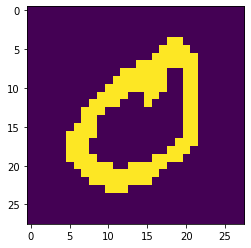

In [73]:
plt.imshow(arr[5].reshape(28,28))